---
title: Projet 4
publishDate: 2020-03-04 00:00:00
img: /assets/stock-3.jpg
img_alt: Pearls of silky soft white cotton, bubble up under vibrant lighting
description: |
  We developed a virtual showcase for the softest bedding imaginable.
tags:
  - Design
  - Dev
  - Branding
---

<script>
MathJax = {
  	tex: {
    	inlineMath: [['$', '$'], ['\\(', '\\)']]
  	},
  	svg: {
    fontCache: 'global'
  	}
};
</script>


### 1. Introduction

<p style="text-align: justify;">
Dans cette unité d'enseignement, nous allons approfondir les connaissances techniques de la méthode des éléments finis. Pour cela, nous aborderons la résolution des systèmes non-linéaires et les problématiques liées. Cet apprentissage sera fait à travers une série de travaux pratiques où seront développés des codes EF en python/C++ à l'aide de la librairie FEniCS (librairie open-source), ceci donnant une approche informatique (High Performance Computing) de cet enseignement souvent appelée mécanique numérique.
</P> 

####  Python

<p style="text-align: justify;">
Python est un langage de programmation très largement utilisé dans les environnements académiques et industriels. Sa syntaxe est pour plusieurs aspects similaire à celle de Matlab.
</P> 

<p style="text-align: justify;">
À la différence de Matlab, Python est un logiciel libre. Un nombre croissant de librairies dédiées à la résolution de problèmes spécifiques (modules) est disponible librement. Deux modules sont indispensables pour les calculs scientifiques : matplotlib et numpy. Une large documentation et différents cours à tous les niveaux sont disponibles en ligne (cf Bibliographie).
</P> 

####  FEniCS

<p style="text-align: justify;">
FEniCS est un projet collaboratif développé par un groupe d'instituts de recherche à travers le monde. La librairie est distribuée gratuitement. FEniCS fournit une infrastructure avancée et moderne pour la résolution numérique des Équations aux Dérivées Partielles (EDP) par la méthode des éléments finis. Nous utiliserons l'interface Python de FEniCS, qui est chargée comme un module de Python à partir d'une console ou d'un script python, avec la commande :
</P> 

Tout problème d'éléments finis peut être construit de la manière suivante :

  1. Description de la géométrie, maillage. Choix du support géométrique.
  2. Choix du type d'éléments finis et du modèle de comportement.
  3. Données des caractéristiques du matériau et de la géométrie supplémentaire.
  4. Données des conditions aux limites.
  5. Données du chargement.
  6. Résolution du système.
  7. Post-traitement des résultats.

<p style="text-align: justify;">
L'objectif de ce premier TP est alors de résoudre avec FEniCS un problème de conduction thermique stationnaire (équation de Poisson).
</P> 

### 2. Prise en main de Fenics : Équation de Poisson

<p style="text-align: justify;">
Pour comprendre comment est structuré un script Python permettant la résolution d'un problème EDP à l'aide de FEniCS, nous allons suivre pas à pas l'exemple décrit dans le tutoriel du code, puis nous en inspirer pour résoudre un problème simple de thermique.
</P> 

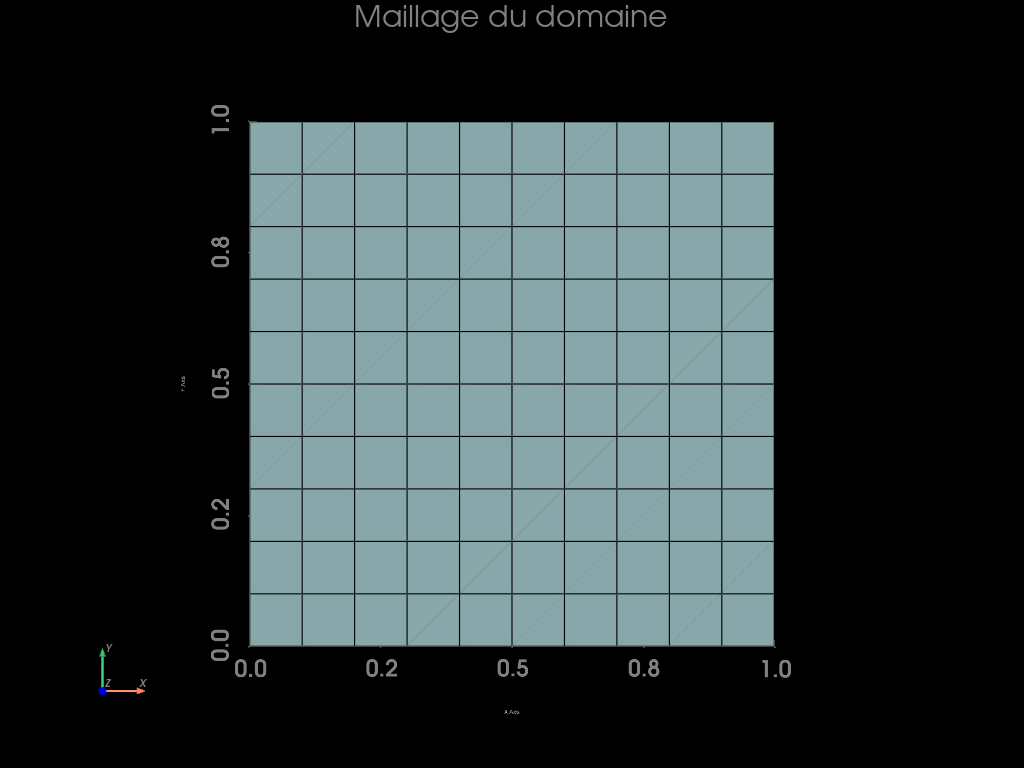

In [1]:
# Importation des modules nécessaires
from mpi4py import MPI # Importation de MPI pour activer le calcul parallèle
import numpy as np # Importation de NumPy pour la gestion des tableaux et les opérations numériques

# Génération du maillage d'un carré unité
from dolfinx import mesh # Importation du module de maillage de DOLFINx
# Création d'un maillage carré unitaire avec des éléments quadrilatéraux, partagé entre les processus MPI
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10, mesh.CellType.quadrilateral)

# Création de la connectivité entre les facettes et les cellules pour déterminer les facettes frontières
tdim = domain.topology.dim # Obtenir la dimension topologique du maillage (2D pour un carré)
fdim = tdim - 1 # Définir la dimension des facettes du maillage (1D pour les bords d'un carré 2D)
domain.topology.create_connectivity(fdim, tdim) # Créer la connectivité entre les facettes (1D) et les cellules (2D) du maillage
boundary_facets = mesh.exterior_facet_indices(domain.topology) # Obtenir les indices des facettes extérieures du maillage (les bords du carré)

# Visualisation du maillage avec PyVista
import pyvista # Importation du module PyVista pour la visualisation 3D et la création de graphiques
from dolfinx import plot # Importation du module de tracé de DOLFINx pour la visualisation des maillages et des solutions
domain.topology.create_connectivity(tdim, tdim) # Crée la connectivité de la topologie du maillage entre les entités de dimension tdim (cellules)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim) # Convertit le maillage en format compatible VTK pour la visualisation
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry) # Crée une grille non structurée PyVista pour la visualisation basée sur la topologie, les types de cellules et la géométrie

# Configuration du plotter PyVista
plotter = pyvista.Plotter() # Création d'un objet Plotter PyVista
plotter.show_bounds(color="grey") # Affichage des limites du plot avec des lignes grises
plotter.add_axes(color="grey") # Ajout des axes du plot avec des lignes grises
plotter.set_background("black") # Définition de l'arrière-plan du plot en noir
plotter.add_mesh(grid, show_edges=True) # Ajout du maillage (grid) au plot avec les bords visibles (show_edges=True)
plotter.view_xy() # Vue XY (vue par défaut)
plotter.add_text("Maillage du domaine", font_size=12, color="grey", position="upper_edge") # Ajout d'un texte ("Maillage du domaine") en gris en haut du plot
if not pyvista.OFF_SCREEN: # Affichage du plot s'il n'est pas en mode OFF_SCREEN (fenêtre interactive)
    plotter.show()
else: # Capture d'écran du plot pour sauvegarde si en mode OFF_SCREEN
    figure = plotter.screenshot("fundamentals_mesh.png")

In [2]:
from dolfinx.fem import functionspace # Importation de la fonction pour créer un espace de fonctions
from dolfinx import fem  # Importation des fonctionnalités de FEniCSx pour la mécanique des solides

V = fem.functionspace(domain, ("Lagrange", 1)) # Création de l'espace de fonctions de type Lagrange d'ordre 1

# Définition de la formulation variationnelle
import ufl # Importation du module UFL pour la définition symbolique des fonctions
u = ufl.TrialFunction(V)  # Définition de la fonction d'essai u dans l'espace de fonctions V
v = ufl.TestFunction(V)# Définition de la fonction d'essai v dans l'espace de fonctions V

# Définition de la source et des formes bilinéaire et linéaire
from dolfinx import default_scalar_type # Importation du type scalaire par défaut
from petsc4py import PETSc  # Importation de PETSc pour les calculs parallèles et la manipulation de matrices
f = fem.Constant(domain, PETSc.ScalarType(-6.0))
a = ufl.dot(ufl.grad(v), ufl.grad(u)) * ufl.dx     # Définition de la forme bilinéaire a pour le problème variationnel
L = f * v * ufl.dx                               # Définition de la forme linéaire L pour le problème variationnel

# Conditions aux limites (Dirichlet)
u_D = fem.Function(V) # Définition d'une fonction u_D dans l'espace de fonctions V
u_D.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2) # Interpolation de u_D avec une fonction lambda quadratique
bc = fem.dirichletbc(u_D, fem.locate_dofs_geometrical(V, lambda x: np.full(x.shape[1], True, dtype=bool))) # Définition des conditions de Dirichlet sur u_D

# Résolution du problème variationnel
uh = fem.Function(V) # Définition d'une fonction uh dans l'espace de fonctions V
from dolfinx.fem.petsc import LinearProblem # Importation du problème linéaire PETSc
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"}) # Définition du problème linéaire avec les conditions de Dirichlet bc
uh = problem.solve()  # Résolution du problème linéaire pour trouver uh

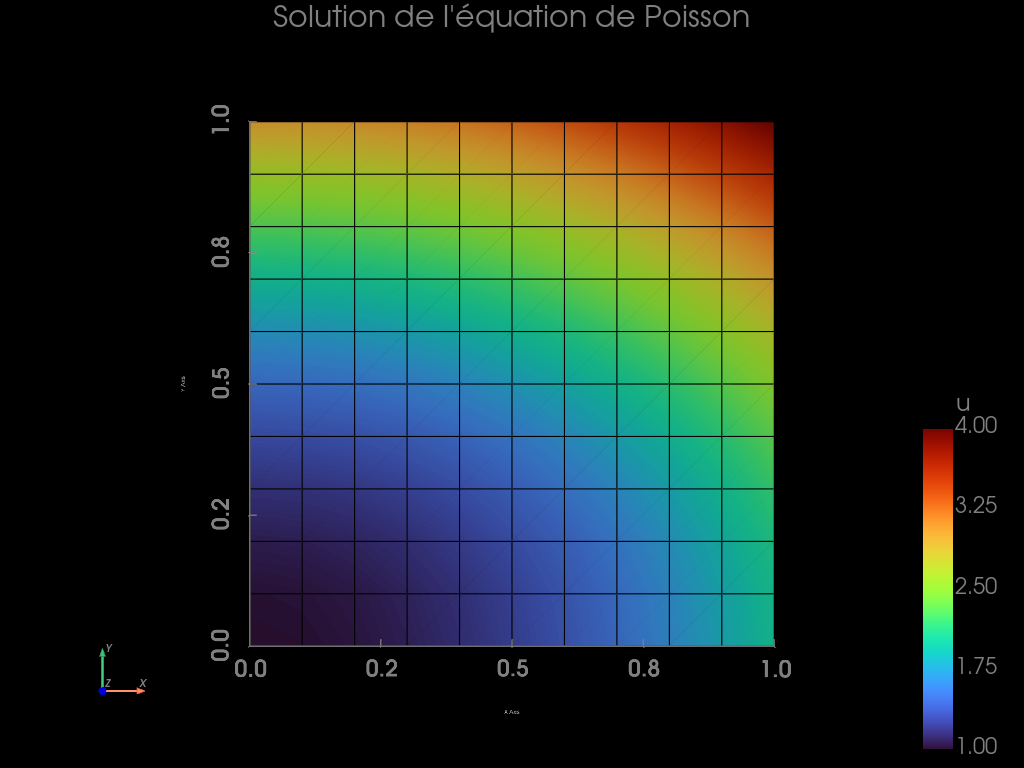

In [3]:
# Préparation des données pour la visualisation
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry) # Crée un objet pyvista.UnstructuredGrid avec la topologie, les types de cellules et la géométrie fournis
u_grid.point_data["u"] = uh.x.array.real # Associe les valeurs réelles de la solution uh aux données de points "u" sur le maillage u_grid
u_grid.set_active_scalars("u") # Définit "u" comme le scalaire actif sur le maillage u_grid, utilisé pour la visualisation ou l'exportation

# Configuration du plotter PyVista pour la solution
u_plotter = pyvista.Plotter()
u_plotter.set_background("black")
u_plotter.add_mesh(u_grid, show_edges=True, cmap="turbo", show_scalar_bar=False)  # Pas de barre de couleurs initiale

# Ajout d'une barre de couleurs personnalisée
scalar_bar = u_plotter.add_scalar_bar(
    color="grey",  # Couleur du texte de la barre scalaire
    title="u",  # Titre de la barre scalaire
    title_font_size=24,  # Taille de police du titre
    label_font_size=22,  # Taille de police des étiquettes
    shadow=False,  # Désactiver l'ombre
    n_labels=5,  # Nombre d'étiquettes sur la barre scalaire
    italic=False,  # Texte en italique
    font_family="arial",  # Famille de police du texte
    vertical=True  # Orientation verticale de la barre scalaire
)

# Customisation des axes
u_plotter.show_bounds(color="grey")
u_plotter.add_axes(color="grey")
u_plotter.view_xy()

# Ajouter le titre en gris
u_plotter.add_text("Solution de l'équation de Poisson", font_size=12, color="grey", position="upper_edge")

# Affichage ou sauvegarde de l'image
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("/output/poisson_solution.png")

In [4]:
# Interpolation de la solution exacte pour comparaison
V2 = fem.functionspace(domain, ("Lagrange", 2)) # Définition d'un nouvel espace de fonctions V2 avec un degré de Lagrange 2
uex = fem.Function(V2) # Définition d'une fonction uex dans l'espace de fonctions V2
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2) # Interpolation de uex avec une fonction lambda quadratique

# Calcul de l'erreur L2
import numpy
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx) # Calcul de l'erreur L2
error_local = fem.assemble_scalar(L2_error) # Assemblage de l'erreur locale sur chaque processus MPI
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM)) # Calcul de l'erreur L2 totale en prenant la racine carrée de la somme des erreurs locales

# Calcul de l'erreur maximale
error_max = numpy.max(numpy.abs(u_D.x.array - uh.x.array)) # Calcul de l'erreur maximale entre la solution exacte et la solution numérique

# Affichage des erreurs seulement sur un processus (rank) spécifique (rank 0 dans ce cas)
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")


Error_L2 : 5.27e-03
Error_max : 0.00e+00


In [5]:
from dolfinx import io  # Importe le module d'entrée/sortie de DolfinX pour la manipulation des fichiers VTK
from pathlib import Path  # Importe la classe Path de Python pour la gestion des chemins de fichiers
import os

current_directory = Path(os.getcwd()) # Obtenir le chemin du répertoire de travail actuel
parent_directory = current_directory.parent # Aller un niveau en arrière
results_folder = parent_directory / "ParaviewProjet4" # Définir le chemin du dossier de résultats dans le répertoire parent
results_folder.mkdir(exist_ok=True, parents=True) # Créer le dossier de résultats s'il n'existe pas
filename = results_folder / "fundamentals"  # Définit le nom de base du fichier de sortie comme "fundamentals" dans "results"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)  # Écrit les données du champ `uh` au format VTK dans un fichier ".bp"

with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)  # Écrit le maillage dans le fichier XDMF
    xdmf.write_function(uh)  # Écrit le champ de solution `uh` dans le fichier XDMF

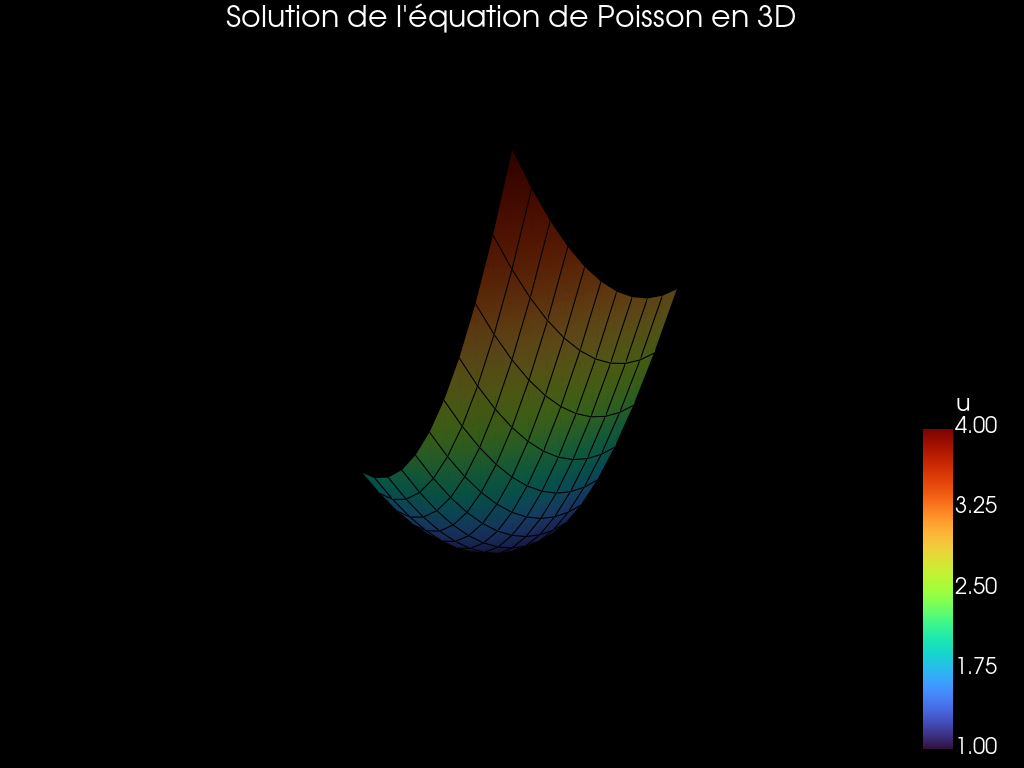

In [6]:
# Visualisation de la solution en 3D
# Cette ligne applique une déformation au maillage u_grid en fonction des valeurs scalaires associées
warped = u_grid.warp_by_scalar() 

plotter2 = pyvista.Plotter()
plotter2.set_background("black")
plotter2.add_mesh(warped, show_edges=True, cmap="turbo", show_scalar_bar=False)

scalar_bar = plotter2.add_scalar_bar(
    color="white",  
    title="u",
    title_font_size=24,
    label_font_size=22,
    shadow=False,
    n_labels=5,
    italic=False,
    font_family="arial",
    vertical=True  
)

plotter2.add_text("Solution de l'équation de Poisson en 3D", font_size=12, color="white", position="upper_edge")

if not pyvista.OFF_SCREEN:
    plotter2.show()


### 3. Problème de conduction thermique stationnaire

<p style="text-align: justify;">
On considère un disque en aluminium de rayon \( R = 1 \, m \), et de faible épaisseur.
</P> 

##### Conditions imposées:

<p style="text-align: justify;">
- **Source interne de chaleur uniforme :**
  \( f = 100 \, W/m^2 \) dans \( \Omega \)
- **Paroi extérieure isotherme de température uniforme \( T_d \) :**
  \( T_d = 25^{\circ}C \) sur \( \Gamma_{ext} \)
</P> 

##### Notation des variables :

<p style="text-align: justify;">
- \( T(x,y) \) : champ de température dans le disque
- \( \mathbf{q}(x,y) = -k\,\nabla T(x,y) \) : vecteur flux de chaleur
- \( k = 0.92 \times W\,m^{-1} \,K^{-1} \) : diffusivité thermique du disque
</P> 

<p style="text-align: justify;">
Les phénomènes de convection et de radiation sont négligés.
</P> 

#### Établissons la formulation forte du problème :

##### Équation d'équilibre thermique (stationnaire) :

$$
div\,\mathbf{q}(x,y)=f
\tag{1}
$$

##### Loi de Fourier :
$$
\mathbf{q}(x,y)=-k\,\nabla T(x,y)
\tag{2}
$$

##### Conditions aux limites :

En température :
$$
T(x,y)=T_d \quad sur \quad \Gamma_{ext}
\tag{3}
$$

<p style="text-align: justify;">
**Remarque**: Le problème est de type 1 car nous connaissons toutes les valeurs scalaires (ici 2 car problème plan) en température sur le pourtour du domaine.
</P> 

#### Résolution analytique :
<p style="text-align: justify;">
En injectant (2) dans (1) nous obtenons :
</P> 
$$
-k\,\Delta T(x,y)=f
$$

<p style="text-align: justify;">
En coordonnées polaires le problème est indépendant de $\theta$ (géométrie de symétrie radiale) et nous avons :
</P> 

$$
\frac{1}{r} \frac{\partial  }{\partial r} \big(r \frac{\partial T(r)}{\partial r}\big)=-\frac{f}{k}
$$

<p style="text-align: justify;">
En intégrant deux fois cette équation par rapport à la seule variable $r$ il vient :
</P> 

$$
T(r)=-\dfrac{fr^2}{4k}+Aln(r)+B
$$

<p style="text-align: justify;">
En $r=0$ la température est finie, on a donc $A=0$, et en $r=R$ la température vaut $T^d$, on a donc:
</P> 

$$
T(r)=\dfrac{f}{4k}(R^2-r^2)+T_d
$$

<p style="text-align: justify;">
Nous retrouvons le champ de température de l'énoncé en posant $r=x^2+y^2$.
</P> 

#### Établissons la formulation faible du problème

<p style="text-align: justify;">
L'équation locale d'équilibre (1) peut être exprimée par une forme intégrale équivalente par dualisation, c'est-à-dire par multiplication par un champ de température virtuelle $T^{\ast}$ $\in$ $\Theta$ et intégration sur le support géométrique $\Omega$.
</P> 

<p style="text-align: justify;">
Introduisons d'abord les ensembles de champ admissible par rapport aux données du problème considéré:
</P>

<p style="text-align: justify;">
L'ensemble de champ thermiquement admissible est défini par :
</P> 

$$
\Theta = \{T^{\ast} \in H^1(\Omega) \, \vert \, T^{\ast}=T_d \quad sur \quad \Gamma_{ext} \}
$$

<p style="text-align: justify;">
L'ensemble de champ thermiquement admissible à zéro est défini par :
</P> 

$$
\hat{\Theta} = \{T^{\ast} \in H^1_0(\Omega) \, \vert \, T^{\ast}=0 \quad sur \quad \Gamma_{ext} \}
\tag{4}
$$

<p style="text-align: justify;">
**Remarque**: Les fonctions $T^{\ast}$ et $T$ doivent être suffisamment régulières puisque la formulation locale requiert a priori un champ de température admissible deux fois continûment différentiable par morceaux. Ainsi, l'espace de Sobolev $H^1$ ($\Omega$) dont les fonctions sont de carré intégrable suffit pour vérifier cette condition.
</P> 

$$
-\int_{\Omega}k(\Delta{T})T^{\ast}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

On utilise ensuite la relation suivante :
$$ 
div(f\mathbf{v})=fdiv\mathbf{v}+\mathbf{v}\cdot\mathbf{grad}f
$$

Ce qui nous ramène à:
$$
-\int_{\Omega}\{k\,div(T^{\ast}\mathbf{\nabla}T)-k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}\}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

Puis à l'aide du théorème d'Ostrogradski :
$$
-\int_{\partial\Omega}\{kT^{\ast}\mathbf{\nabla}T\cdot\mathbf{n}-k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}\}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

et d'après (4) on a $T^{\ast}=0$ sur $\Gamma_{ext}=\partial\Omega$ ce qui donne:
$$
\int_{\partial\Omega}k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

Finalement, la formulation faible du problème s'écrit :

Trouver $T$ $\in$ $\Theta$ tel que:
$$
a(T,T^{\ast}) = L(T^{\ast}) \qquad \forall T^{\ast} \, \in \, \hat{\Theta} 
\tag{5}
$$

avec
$$
a(T,T^{\ast})=\int_{\partial\Omega}k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}dV
$$
qui est une forme bilinéaire, continue et coercive ;

$$
L(T^{\ast})= \int_{\Omega}fT^{\ast}dV 
$$
qui est une forme linéaire et continue.

<p style="text-align: justify;">
**Remarque**: La formulation intégrale écrite ci-dessous correspond en fait au principe des travaux virtuels; puisque l'inconnue $T$ est un scalaire. La formulation faible pour un problème cinématique serait équivalente au principe des puissances virtuelles puisque l'inconnue $\mathbf{u}$ est un vecteur.
</P> 

<p style="text-align: justify;">
La solution analytique de l'équation (5) est en général inaccessible puisque les ensembles de champ admissible sont de dimension infinie. On est donc conduit à chercher une solution approchée par une méthode numérique : la méthode des éléments finis. Cette méthode est un cas particulier de la méthode de Galerkin.
</P> 

<p style="text-align: justify;">
Ainsi, on discrétise **la formulation faible du problème thermique continu** en introduisant respectivement un sous espace des fonctions trial et test : $\Theta_h$ $\subset$ $\Theta$ et $\hat{\Theta}_h$ $\subset$ $\hat{\Theta}$
</P> 

**La formulation faible du problème thermique discret** s'écrit :

Trouver $T_h$ $\in$ $\Theta_h$ tel que:
$$
a(T_h,T_h^{\ast}) = L(T_h^{\ast}) \quad \forall T_h^{\ast} \, \in \, \hat{\Theta}_h 
\tag{6}
$$

avec 

<p style="text-align: justify;">
$$
\quad a(T_h,T^{\ast}_h)=\int_{\partial\Omega}k\mathbf{\nabla}T_h\cdot\mathbf{\nabla}T_h^{\ast}dV
$$
</P> 

et,


$$
\quad L(T_h^{\ast})= \int_{\Omega}fT_h^{\ast}dV 
$$

### 5. Résolution du problème en utilisant FEniCS.

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 8.1e-05s, CPU 0.000125s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0105303s, CPU 0.010543s)
Info    : 411 nodes 821 elements
Valeurs de la condition aux limites: [298. 298. 298. ... 298. 298. 298.]
Solution obtenue: [298.         304.17509609 298.         ... 301.652946   301.11174433
 300.90102848]


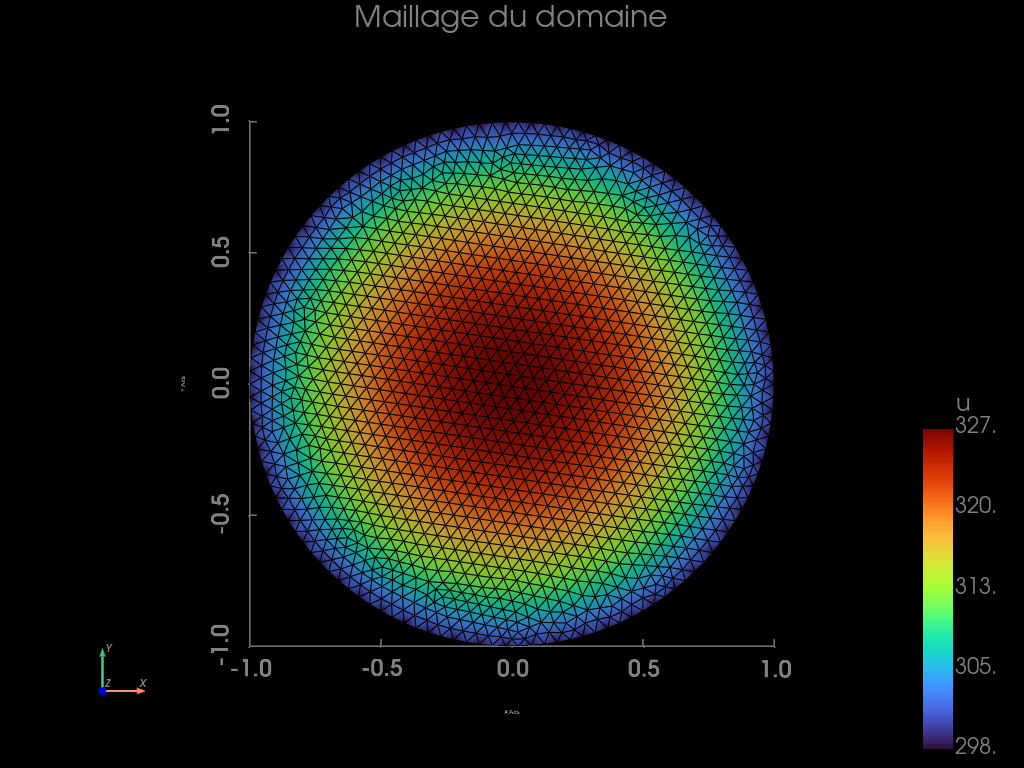

In [7]:
import gmsh
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem, plot
from dolfinx.io import gmshio
from petsc4py import PETSc
import ufl
import pyvista
from dolfinx import default_scalar_type # Importation du type scalaire par défaut
from petsc4py import PETSc  # Importation de PETSc pour les calculs parallèles et la manipulation de matrices

# Initialisation de GMSH
gmsh.initialize()

# Création de la géométrie du disque avec GMSH
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()

# Marquage de la surface physique
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

# Génération du maillage
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.1)
gmsh.model.mesh.generate(gdim)

# Importation du maillage GMSH dans DOLFINx
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

# Fermeture de GMSH
gmsh.finalize()

# Définition de l'espace des fonctions dans DOLFINx
V = fem.functionspace(domain, ("Lagrange", 2))

# Formulation variationnelle du problème
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(100.0))
a = 0.92 * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

# Conditions aux limites
T_D = 298.0
u_D = fem.Function(V)
u_D.interpolate(lambda x: np.full(x.shape[1], T_D))
import numpy as np

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)
bc = fem.dirichletbc(u_D, boundary_dofs)
# Vérification des valeurs de la condition aux limites
print("Valeurs de la condition aux limites:", u_D.x.array)

# Résolution du problème variationnel
from dolfinx.fem.petsc import LinearProblem # Importation du problème linéaire PETSc
uh = fem.Function(V)
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Vérification de la solution obtenue
print("Solution obtenue:", uh.x.array)

# Visualisation de la solution
plotter = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
plotter.show_bounds(color="grey")
plotter.add_axes(color="grey")
plotter.set_background("black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.add_text("Maillage du domaine", font_size=12, color="grey", position="upper_edge")
plotter.add_mesh(u_grid, show_edges=True, cmap="turbo", show_scalar_bar=False)  # Pas de barre scalaire initiale
scalar_bar = plotter.add_scalar_bar(
    color="grey",  # Couleur du texte de la barre scalaire
    title="u",  # Titre de la barre scalaire
    title_font_size=24,  # Taille de police du titre
    label_font_size=22,  # Taille de police des étiquettes
    shadow=False,  # Désactiver l'ombre
    n_labels=5,  # Nombre d'étiquettes sur la barre scalaire
    italic=False,  # Texte en italique
    font_family="arial",  # Famille de police du texte
    vertical=True  # Orientation verticale de la barre scalaire
)
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    # Capture d'écran du plot pour sauvegarde si en mode OFF_SCREEN
    figure = plotter.screenshot("fundamentals_mesh.png")

<p style="text-align: justify;">
Exportons le champ solution sous la forme d'un fichier vtk nommée ThermStat.pvd et affichons le résultat à l'aide du logiciel Paraview.
</P> 

In [8]:
from dolfinx.fem import Function
from dolfinx.io import XDMFFile
import os

## Interpoler la fonction sur un espace de fonctions de même degré que le maillage
V_new = fem.functionspace(domain, ("Lagrange", 1))
uh_interpolated = Function(V_new)
uh_interpolated.interpolate(uh)

current_directory = Path(os.getcwd()) # Obtenir le chemin du répertoire de travail actuel
parent_directory = current_directory.parent # Aller un niveau en arrière
results_folder = parent_directory / "ParaviewProjet4" # Définir le chemin du dossier de résultats dans le répertoire parent
results_folder.mkdir(exist_ok=True, parents=True) # Créer le dossier de résultats s'il n'existe pas


# Enregistrer la solution interpolée au format XDMF
with XDMFFile(domain.comm, "output/ThermStat_adim.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh_interpolated, t=0.0)

# Enregistrer le maillage au format XDMF
with XDMFFile(domain.comm, "output/mesh_circle_adim.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)


### 6. Conclusion

<p style="text-align: justify;">
Ce travail nous a permis de résoudre analytiquement puis numériquement un problème de conduction thermique bidimensionnelle à l'aide des éléments finis et d'évaluer l'erreur de discrétisation.
</P> 